In [1]:
import os
import cv2
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import warnings
warnings.filterwarnings('ignore')
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import RMSprop
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import Sequential, layers
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
import matplotlib.pyplot as plt 
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
import pickle

2024-03-23 13:52:43.710418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 13:52:43.710541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 13:52:43.875286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [3]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete0GKERL/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete0GKERL/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
dataiterator = ds.as_numpy_iterator()

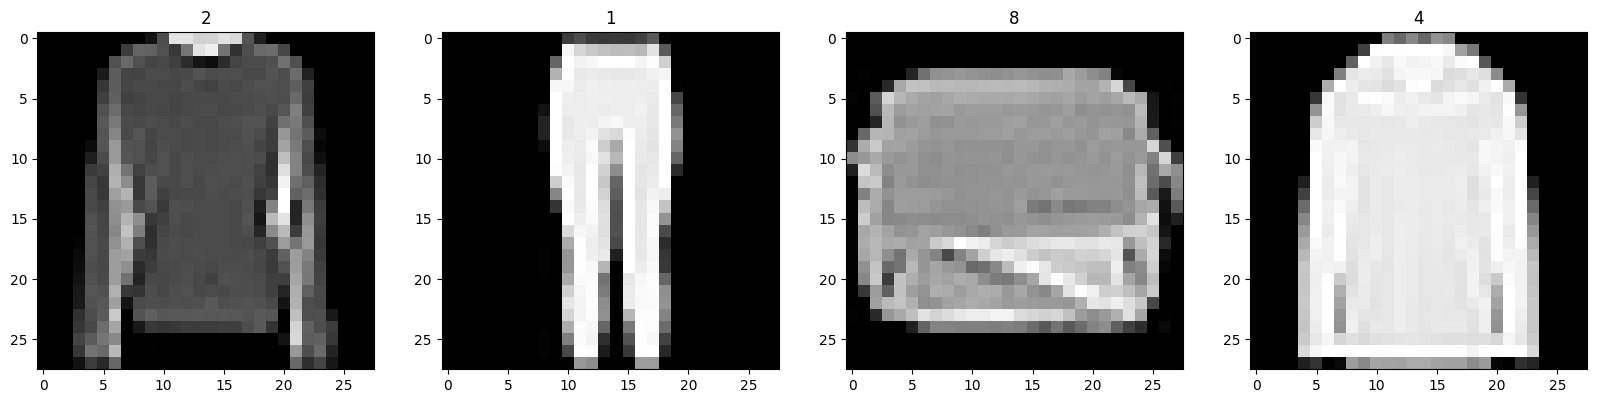

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']), cmap = "gray")
    ax[idx].title.set_text(sample['label'])

In [6]:
def get_training_data():
    # Reload the dataset 
    train_dataset = tfds.load('fashion_mnist', split='train')
#     print(len(train_dataset))
    # Running the dataset through the scale_images preprocessing step
    train_dataset = train_dataset.map(lambda x: x['image']/255) 
    # Cache the dataset for that batch 
    train_dataset = train_dataset.cache()
    # Shuffle it up 
    train_dataset = train_dataset.shuffle(6000)
    # Batch into 128 images per sample
    train_dataset = train_dataset.batch(256)
    
    return train_dataset

In [7]:
train_data=get_training_data()

In [8]:
len(train_data)

235

In [9]:
train_data.as_numpy_iterator().next().shape

(256, 28, 28, 1)

In [10]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(28,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    

    return model

In [11]:
# with strategy.scope():
generator = build_generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │       351,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,427,776 (5.45 MB)

 Trainable params: 1,402,304 (5.35 MB)

 Non-trainable params: 25,472 (99.50 KB)

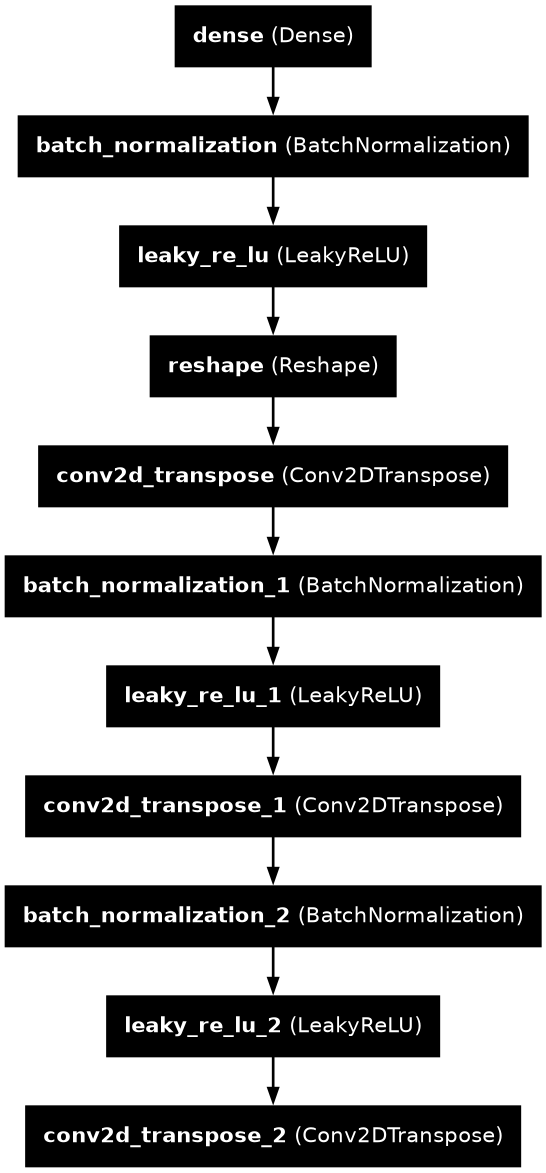

In [12]:
tf.keras.utils.plot_model(
    generator,
    to_file='/kaggle/working/generator.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1711202027.922993      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


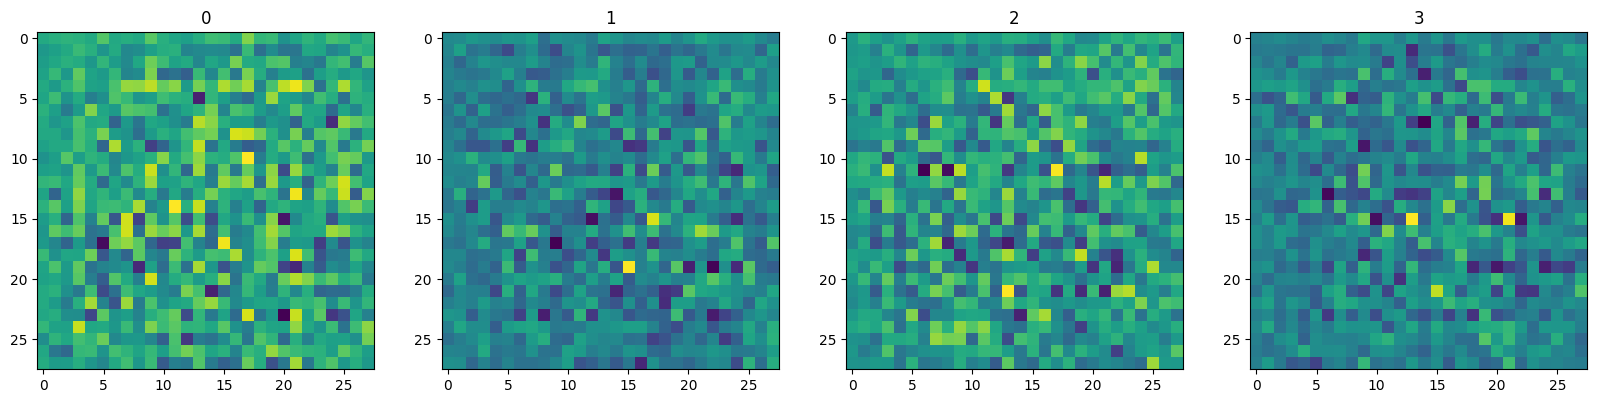

In [13]:
# preds = model.predict(np.random.randn(32,3))

imgs = generator.predict(tf.random.normal((4,28)))
# print(imgs.shape)
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(imgs): 
    # Plot the image using a specific subplot 
#     print(img.shape)
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [14]:
def build_discriminator(): 
#     with strategy.scope():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

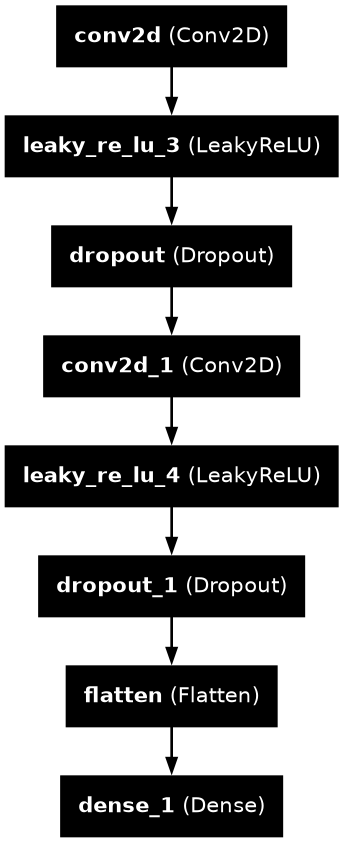

In [16]:
tf.keras.utils.plot_model(
    discriminator,
    to_file='/kaggle/working/discriminator.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [17]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        self.g_losses, self.d_losses = [], []
        self.g_loss_tracker = keras.metrics.Mean(name = "g_loss")
        self.d_loss_tracker = keras.metrics.Mean(name = "d_loss")
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((256, 28,1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        
        
        
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((256,28,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
        

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        self.g_loss_tracker.update_state(total_g_loss)
        self.d_loss_tracker.update_state(total_d_loss)
        return {
            "d_loss":self.d_loss_tracker.result(), 
            "g_loss":self.g_loss_tracker.result()
        }
    @property
    def metrics(self):
        return [ self.d_loss_tracker, self.g_loss_tracker]

In [18]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=28):
        self.num_img = num_img
        self.latent_dim = latent_dim
        

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 == 0:
            # saving the model weights
            self.model.generator.save_weights("/kaggle/working/F_GANgen.weights.h5")
            self.model.discriminator.save_weights("/kaggle/working/F_GANdis.weights.h5")
            
            # saving the generator optimizer config
            gen_config = self.model.g_opt.get_config()
            with open('/kaggle/working/g_optimizer.pkl', 'wb') as f:
                pickle.dump(gen_config, f)
                
            # saving the discriminator optimizer config
            des_config = self.model.d_opt.get_config()
            with open('/kaggle/working/d_optimizer.pkl', 'wb') as f:
                pickle.dump(des_config,f)
            
            # saving the generator and descriminator
#             with open('/kaggle/working/desc.pkl', 'wb') as f:
#                 pickle.dump(self.model.discriminator, f)
                
#             with open('/kaggle/working/gen.pkl', 'wb') as f:
#                 pickle.dump(self.model.generator, f)

            self.model.generator.save('/kaggle/working/gen.keras')
            self.model.discriminator.save('/kaggle/working/des.keras')

                
                
        if epoch % 200 == 0:
            random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            
            for i in range(self.num_img):
                img = array_to_img(generated_images[i])
                img.save(os.path.join('/kaggle/working/', f'generated_img_{epoch}_{i}.png'))

In [19]:
with strategy.scope():
    # Define learning rates
    g_learning_rate = 1e-5
    d_learning_rate = 1e-6

    # Create RMSprop optimizers for generator and discriminator
    g_opt = RMSprop(learning_rate=g_learning_rate)
    d_opt = RMSprop(learning_rate=d_learning_rate)
    g_loss = BinaryCrossentropy()
    d_loss = BinaryCrossentropy()
    generator = build_generator()
    discriminator = build_discriminator()
    f_GAN = FashionGAN(generator, discriminator)
    
    f_GAN.compile(g_opt, d_opt, g_loss, d_loss)


In [20]:
hist = f_GAN.fit(train_data, epochs=2000, callbacks=[ModelMonitor()])

2024-03-23 13:53:54.626246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_132/cond/StatefulPartitionedCall/replica_1/sequential_3_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - d_loss: 14.3990 - g_loss: 9.8864e-04


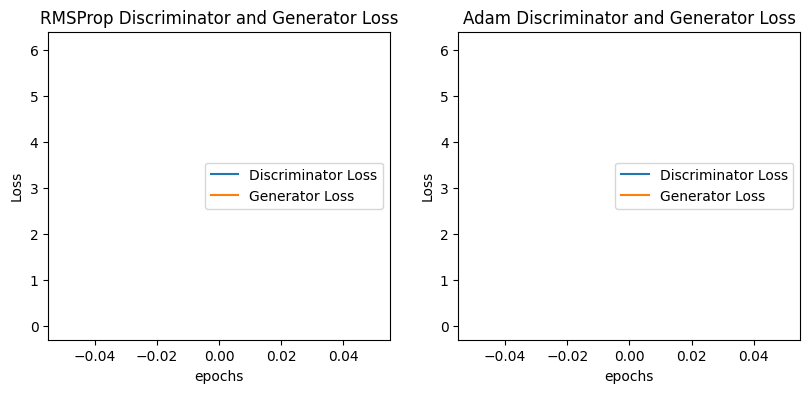

In [21]:
def PlotAccuracy(net):
  plt.figure(figsize=(15, 4))
  plt.subplot(1,3,1)
  plt.plot(net['d_loss'],label='Discriminator Loss')
  plt.plot(net['g_loss'],label='Generator Loss')
  plt.title("RMSProp Discriminator and Generator Loss")
  plt.ylabel('Loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.plot()


  plt.subplot(1,3,2)
  plt.plot(net['d_loss'],label='Discriminator Loss')
  plt.plot(net['g_loss'],label='Generator Loss')
  plt.title("Adam Discriminator and Generator Loss")
  plt.ylabel('Loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.plot()

PlotAccuracy(hist.history)

In [22]:
with open("/kaggle/working/Adamaxhistory.pkl","wb") as f:
    pickle.dump(hist.history,f)

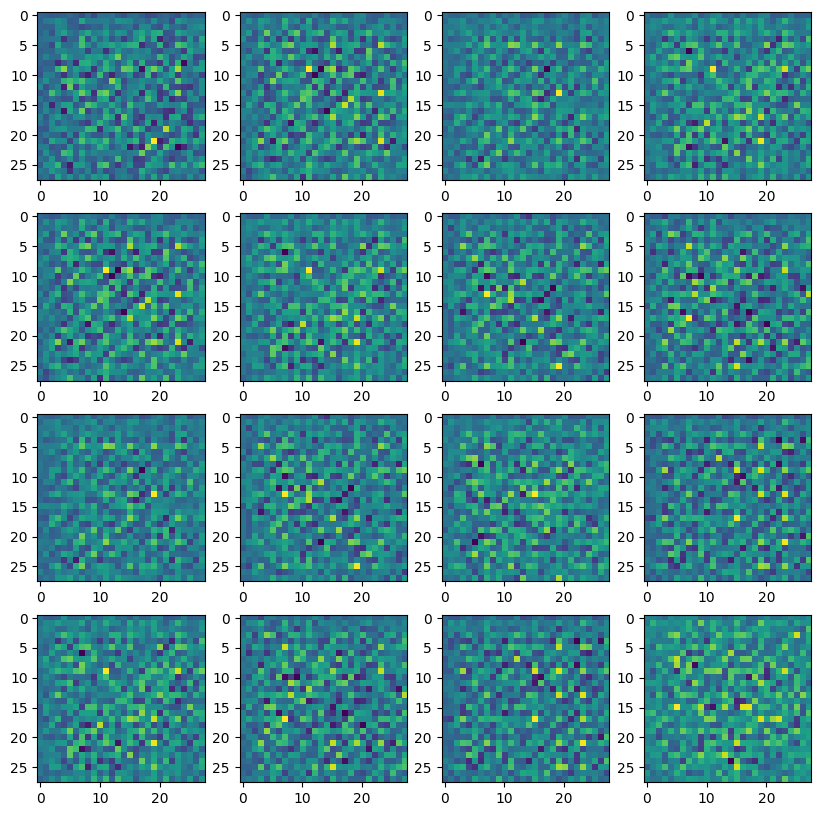

In [23]:
# to be run after the model is trained
imgs = generator(tf.random.normal((16, 28)))

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])


In [24]:
# finally saving the generator and descriminator models

generator.save("/kaggle/working/final_generator_model.keras")
discriminator.save("/kaggle/working/final_descriminator_model.keras")